In [46]:
!pip install onnx

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.5/17.5 MB 57.1 MB/s eta 0:00:00


In [49]:
# 1. Install torchviz (Run this once)
!pip install torchviz graphviz

import torch
import torch.nn as nn
from torchviz import make_dot
from torchvision import models

# 2. Define Wrapper to Capture ALL Heads
# (Standard models only show the path taken; this wrapper forces all paths)
class VisualizationWrapper(nn.Module):
    def __init__(self, model):
        super().__init__()
        self.model = model

    def forward(self, x):
        # Run Backbone
        features = self.model.backbone(x)
        features = nn.functional.adaptive_avg_pool2d(features, (1, 1)).flatten(1)

        # Force all heads to run so they appear in the graph
        h1 = self.model.head1(features)
        h2 = self.model.head2(features)
        h3 = self.model.head3(features)
        h4 = self.model.head4(features)
        h5 = self.model.head5(features)

        return h1, h2, h3, h4, h5

# 3. Load Your Model
# (Assuming 'model' is already loaded from previous cells)
viz_model = VisualizationWrapper(model)

# 4. Generate Graph
dummy_input = torch.randn(1, 1, 224, 224).to(next(model.parameters()).device)
output = viz_model(dummy_input)

# 5. Render
dot = make_dot(output, params=dict(model.named_parameters()))
dot.format = 'png'
dot.render("hierarchical_architecture")

# 6. Display
from IPython.display import Image
Image("hierarchical_architecture.png")

In [10]:
import os
import shutil
from PIL import Image
from tqdm import tqdm
from google.colab import drive

# ==========================================
# 1. CONFIGURATION
# ==========================================
drive.mount('/content/drive')

SOURCE_PATH = "/content/drive/MyDrive/Particle"
PROCESSED_PATH = "/content/processed_dataset_224_upscaledParticle"

# ==========================================
# 2. STANDARD UPSCALING FUNCTION
# ==========================================
def standard_upscale(img, target_size=(224, 224)):
    """
    Upscales the image using High-Quality Bicubic Interpolation.
    Fills the entire 224x224 frame.
    """
    # 1. Convert to Grayscale
    img = img.convert('L')

    # 2. Resize (Bicubic is best for enlarging)
    # This creates new pixels smoothly, making features larger
    img = img.resize(target_size, Image.Resampling.BICUBIC)

    return img

# ==========================================
# 3. EXECUTE PROCESSING
# ==========================================
if os.path.exists(PROCESSED_PATH):
    shutil.rmtree(PROCESSED_PATH)

print(f"Upscaling images from {SOURCE_PATH} -> {PROCESSED_PATH} ...")

supported_ext = ('.jpg', '.jpeg', '.png', '.bmp', '.tif', '.tiff')
file_count = 0

for root, dirs, files in os.walk(SOURCE_PATH):
    for file in files:
        if file.lower().endswith(supported_ext):
            src_file = os.path.join(root, file)

            # Maintain structure
            rel_path = os.path.relpath(root, SOURCE_PATH)
            dest_folder = os.path.join(PROCESSED_PATH, rel_path)
            os.makedirs(dest_folder, exist_ok=True)

            dest_file = os.path.join(dest_folder, file)

            try:
                with Image.open(src_file) as img:
                    processed_img = standard_upscale(img)
                    processed_img.save(dest_file)
                    file_count += 1
            except Exception as e:
                print(f"Error: {e}")

print(f"\n✅ Success! {file_count} images upscaled to 224x224 (No black borders).")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Upscaling images from /content/drive/MyDrive/Particle -> /content/processed_dataset_224_upscaledParticle ...

✅ Success! 30 images upscaled to 224x224 (No black borders).


In [8]:
import torch
import torch.nn as nn
from torchvision import transforms, models
from PIL import Image
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import pandas as pd

# ==========================================
# 1. CONFIGURATIONimport torch
import torch.nn as nn
from torchvision import transforms, models
from PIL import Image
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import pandas as pd

# ==========================================
# 1. CONFIGURATION
# ==========================================
# Path to the UPSCALED dataset (from previous step)
DATASET_DIR = "/content/processed_dataset_224_upscaledOpen"
MODEL_FILE = "sem_hierarchical_eiq_final.pth"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ==========================================
# 2. MODEL DEFINITION
# ==========================================
class HierarchicalModel(nn.Module):
    def __init__(self):
        super().__init__()
        # Initialize MobileNetV3
        base = models.mobilenet_v3_small(weights=None)
        self.backbone = base.features
        # Fix first layer for Grayscale (1 channel)
        self.backbone[0][0] = nn.Conv2d(1, 16, 3, 2, 1, bias=False)

        # Define Heads (Must match training)
        self.head1 = self._make_head(576, 2)
        self.head2 = self._make_head(576, 3)
        self.head3 = self._make_head(576, 2)
        self.head4 = self._make_head(576, 2)
        self.head5 = self._make_head(576, 2)

    def _make_head(self, in_dim, out_dim):
        return nn.Sequential(
            nn.Linear(in_dim, 128),
            nn.Hardswish(),
            nn.Dropout(0.2),
            nn.Linear(128, out_dim)
        )

    def forward_conditional(self, x):
        """
        Runs the hierarchical logic:
        1. Check H1 (Normal vs Defect).
        2. If Defect, check H2 (Type).
        3. Based on Type, check specific Subtype Head (H3, H4, or H5).
        Returns: Dictionary of predictions and a string describing the path.
        """
        preds = {}
        path_list = []

        # Backbone Feature Extraction
        features = self.backbone(x)
        features = nn.functional.adaptive_avg_pool2d(features, (1, 1)).flatten(1)

        # --- HEAD 1 ---
        h1 = torch.argmax(self.head1(features), dim=1).item()
        preds['h1'] = h1

        if h1 == 0:
            return preds, "H1: Normal" # Stop Early

        path_list.append("H1: Defect")

        # --- HEAD 2 ---
        h2 = torch.argmax(self.head2(features), dim=1).item()
        preds['h2'] = h2
        type_names = ["Type A (CMP)", "Type B (LER)", "Type C (Open)"]
        path_list.append(f"H2: {type_names[h2]}")

        # --- BRANCHING ---
        if h2 == 0:
            h3 = torch.argmax(self.head3(features), dim=1).item()
            preds['h3'] = h3
            path_list.append(f"H3: Subtype {h3}")
        elif h2 == 1:
            h4 = torch.argmax(self.head4(features), dim=1).item()
            preds['h4'] = h4
            path_list.append(f"H4: Subtype {h4}")
        elif h2 == 2:
            h5 = torch.argmax(self.head5(features), dim=1).item()
            preds['h5'] = h5
            path_list.append(f"H5: Subtype {h5}")

        return preds, " -> ".join(path_list)

# ==========================================
# 3. HELPER: PARSE GROUND TRUTH
# ==========================================
def get_ground_truth(file_path):
    """
    Infers labels based on folder names in the path.
    Adapts to: defect/cmp_crack/cmp OR defect/cmp_crack/crack etc.
    """
    parts = file_path.split(os.sep)
    labels = {}

    # Check for Normal
    if "normal" in parts: return {'h1': 0}

    # Check for Defect
    if "defect" in parts:
        labels['h1'] = 1

        # Check Type (H2)
        if "cmp_crack" in parts:
            labels['h2'] = 0
            # Check Subtypes (H3)
            if "cmp" in parts: labels['h3'] = 0
            elif "crack" in parts: labels['h3'] = 1

        elif "ler_incetch" in parts:
            labels['h2'] = 1
            # Check Subtypes (H4)
            if "inc_etch" in parts: labels['h4'] = 0
            elif "ler" in parts: labels['h4'] = 1

        elif "open_bridge" in parts:
            labels['h2'] = 2
            # Check Subtypes (H5)
            if "open" in parts: labels['h5'] = 0
            elif "bridge" in parts: labels['h5'] = 1

    return labels

# ==========================================
# 4. RUN EVALUATION LOOP
# ==========================================
# Load Model
model = HierarchicalModel().to(device)
if os.path.exists(MODEL_FILE):
    model.load_state_dict(torch.load(MODEL_FILE, map_location=device))
    model.eval()
    print("✅ Model loaded successfully.")
else:
    raise FileNotFoundError(f"❌ Model file '{MODEL_FILE}' not found.")

# Transform (No resize needed, images are already 224x224)
transform = transforms.ToTensor()

# Find all images
image_paths = glob.glob(os.path.join(DATASET_DIR, "**", "*.*"), recursive=True)
valid_exts = ('.jpg', '.jpeg', '.png', '.bmp', '.tif', '.tiff')
image_paths = [p for p in image_paths if p.lower().endswith(valid_exts)]

print(f"Evaluating {len(image_paths)} images...")

metrics = {k: {'true': [], 'pred': []} for k in ['h1', 'h2', 'h3', 'h4', 'h5']}
folder_paths = {}

for img_path in image_paths:
    true_labels = get_ground_truth(img_path)
    # Get folder name relative to dataset root
    rel_folder = os.path.dirname(os.path.relpath(img_path, DATASET_DIR))

    try:
        img = Image.open(img_path) # Already processed/upscaled
        img_t = transform(img).unsqueeze(0).to(device)

        with torch.no_grad():
            preds, path_str = model.forward_conditional(img_t)

        # Log Path
        if rel_folder not in folder_paths: folder_paths[rel_folder] = []
        folder_paths[rel_folder].append(path_str)

        # Log Metrics (Only if we have ground truth for that head)
        for head in metrics:
            if head in true_labels and head in preds:
                metrics[head]['true'].append(true_labels[head])
                metrics[head]['pred'].append(preds[head])

    except Exception as e:
        # print(f"Error reading {img_path}: {e}")
        pass

# ==========================================
# 5. VISUALIZE RESULTS
# ==========================================

# A. CONFUSION MATRICES
active_heads = [h for h in metrics if len(metrics[h]['true']) > 0]

if active_heads:
    print("\n" + "="*60)
    print("   CONFUSION MATRIX REPORT")
    print("="*60)

    plt.figure(figsize=(5 * len(active_heads), 4))

    for idx, head in enumerate(active_heads):
        y_true = metrics[head]['true']
        y_pred = metrics[head]['pred']

        # Accuracy Calculation
        acc = np.mean(np.array(y_true) == np.array(y_pred)) * 100

        # Plot
        plt.subplot(1, len(active_heads), idx+1)
        cm = confusion_matrix(y_true, y_pred)
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
        plt.title(f"{head.upper()} Accuracy: {acc:.1f}%\n(n={len(y_true)})")
        plt.xlabel("Predicted")
        plt.ylabel("True")

    plt.tight_layout()
    plt.show()
else:
    print("⚠️ No metrics collected. Check if ground truth labels matched your folder names.")

# B. DECISION PATH REPORT
print("\n" + "="*60)
print("   DECISION PATH REPORT (Folder-wise)")
print("="*60)

sorted_folders = sorted(folder_paths.keys())

for folder in sorted_folders:
    print(f"\n📂 {folder}")
    paths = folder_paths[folder]
    if not paths: continue

    counts = pd.Series(paths).value_counts()
    for path, count in counts.items():
        pct = (count / len(paths)) * 100
        # Simple ascii bar
        bar_len = int(pct / 5)
        bar = "█" * bar_len
        print(f"   [{count:3d} | {pct:5.1f}%] {path}")
# ==========================================
# Path to the UPSCALED dataset (from previous step)
DATASET_DIR = "/content/processed_dataset_224_upscaled"
MODEL_FILE = "sem_hierarchical_eiq_final.pth"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ==========================================
# 2. MODEL DEFINITION
# ==========================================
class HierarchicalModel(nn.Module):
    def __init__(self):
        super().__init__()
        # Initialize MobileNetV3
        base = models.mobilenet_v3_small(weights=None)
        self.backbone = base.features
        # Fix first layer for Grayscale (1 channel)
        self.backbone[0][0] = nn.Conv2d(1, 16, 3, 2, 1, bias=False)

        # Define Heads (Must match training)
        self.head1 = self._make_head(576, 2)
        self.head2 = self._make_head(576, 3)
        self.head3 = self._make_head(576, 2)
        self.head4 = self._make_head(576, 2)
        self.head5 = self._make_head(576, 2)

    def _make_head(self, in_dim, out_dim):
        return nn.Sequential(
            nn.Linear(in_dim, 128),
            nn.Hardswish(),
            nn.Dropout(0.2),
            nn.Linear(128, out_dim)
        )

    def forward_conditional(self, x):
        """
        Runs the hierarchical logic:
        1. Check H1 (Normal vs Defect).
        2. If Defect, check H2 (Type).
        3. Based on Type, check specific Subtype Head (H3, H4, or H5).
        Returns: Dictionary of predictions and a string describing the path.
        """
        preds = {}
        path_list = []

        # Backbone Feature Extraction
        features = self.backbone(x)
        features = nn.functional.adaptive_avg_pool2d(features, (1, 1)).flatten(1)

        # --- HEAD 1 ---
        h1 = torch.argmax(self.head1(features), dim=1).item()
        preds['h1'] = h1

        if h1 == 0:
            return preds, "H1: Normal" # Stop Early

        path_list.append("H1: Defect")

        # --- HEAD 2 ---
        h2 = torch.argmax(self.head2(features), dim=1).item()
        preds['h2'] = h2
        type_names = ["Type A (CMP)", "Type B (LER)", "Type C (Open)"]
        path_list.append(f"H2: {type_names[h2]}")

        # --- BRANCHING ---
        if h2 == 0:
            h3 = torch.argmax(self.head3(features), dim=1).item()
            preds['h3'] = h3
            path_list.append(f"H3: Subtype {h3}")
        elif h2 == 1:
            h4 = torch.argmax(self.head4(features), dim=1).item()
            preds['h4'] = h4
            path_list.append(f"H4: Subtype {h4}")
        elif h2 == 2:
            h5 = torch.argmax(self.head5(features), dim=1).item()
            preds['h5'] = h5
            path_list.append(f"H5: Subtype {h5}")

        return preds, " -> ".join(path_list)

# ==========================================
# 3. HELPER: PARSE GROUND TRUTH
# ==========================================
def get_ground_truth(file_path):
    """
    Infers labels based on folder names in the path.
    Adapts to: defect/cmp_crack/cmp OR defect/cmp_crack/crack etc.
    """
    parts = file_path.split(os.sep)
    labels = {}

    # Check for Normal
    if "normal" in parts: return {'h1': 0}

    # Check for Defect
    if "defect" in parts:
        labels['h1'] = 1

        # Check Type (H2)
        if "cmp_crack" in parts:
            labels['h2'] = 0
            # Check Subtypes (H3)
            if "cmp" in parts: labels['h3'] = 0
            elif "crack" in parts: labels['h3'] = 1

        elif "ler_incetch" in parts:
            labels['h2'] = 1
            # Check Subtypes (H4)
            if "inc_etch" in parts: labels['h4'] = 0
            elif "ler" in parts: labels['h4'] = 1

        elif "open_bridge" in parts:
            labels['h2'] = 2
            # Check Subtypes (H5)
            if "open" in parts: labels['h5'] = 0
            elif "bridge" in parts: labels['h5'] = 1

    return labels

# ==========================================
# 4. RUN EVALUATION LOOP
# ==========================================
# Load Model
model = HierarchicalModel().to(device)
if os.path.exists(MODEL_FILE):
    model.load_state_dict(torch.load(MODEL_FILE, map_location=device))
    model.eval()
    print("✅ Model loaded successfully.")
else:
    raise FileNotFoundError(f"❌ Model file '{MODEL_FILE}' not found.")

# Transform (No resize needed, images are already 224x224)
transform = transforms.ToTensor()

# Find all images
image_paths = glob.glob(os.path.join(DATASET_DIR, "**", "*.*"), recursive=True)
valid_exts = ('.jpg', '.jpeg', '.png', '.bmp', '.tif', '.tiff')
image_paths = [p for p in image_paths if p.lower().endswith(valid_exts)]

print(f"Evaluating {len(image_paths)} images...")

metrics = {k: {'true': [], 'pred': []} for k in ['h1', 'h2', 'h3', 'h4', 'h5']}
folder_paths = {}

for img_path in image_paths:
    true_labels = get_ground_truth(img_path)
    # Get folder name relative to dataset root
    rel_folder = os.path.dirname(os.path.relpath(img_path, DATASET_DIR))

    try:
        img = Image.open(img_path) # Already processed/upscaled
        img_t = transform(img).unsqueeze(0).to(device)

        with torch.no_grad():
            preds, path_str = model.forward_conditional(img_t)

        # Log Path
        if rel_folder not in folder_paths: folder_paths[rel_folder] = []
        folder_paths[rel_folder].append(path_str)

        # Log Metrics (Only if we have ground truth for that head)
        for head in metrics:
            if head in true_labels and head in preds:
                metrics[head]['true'].append(true_labels[head])
                metrics[head]['pred'].append(preds[head])

    except Exception as e:
        # print(f"Error reading {img_path}: {e}")
        pass

# ==========================================
# 5. VISUALIZE RESULTS
# ==========================================

# A. CONFUSION MATRICES
active_heads = [h for h in metrics if len(metrics[h]['true']) > 0]

if active_heads:
    print("\n" + "="*60)
    print("   CONFUSION MATRIX REPORT")
    print("="*60)

    plt.figure(figsize=(5 * len(active_heads), 4))

    for idx, head in enumerate(active_heads):
        y_true = metrics[head]['true']
        y_pred = metrics[head]['pred']

        # Accuracy Calculation
        acc = np.mean(np.array(y_true) == np.array(y_pred)) * 100

        # Plot
        plt.subplot(1, len(active_heads), idx+1)
        cm = confusion_matrix(y_true, y_pred)
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
        plt.title(f"{head.upper()} Accuracy: {acc:.1f}%\n(n={len(y_true)})")
        plt.xlabel("Predicted")
        plt.ylabel("True")

    plt.tight_layout()
    plt.show()
else:
    print("⚠️ No metrics collected. Check if ground truth labels matched your folder names.")

# B. DECISION PATH REPORT
print("\n" + "="*60)
print("   DECISION PATH REPORT (Folder-wise)")
print("="*60)

sorted_folders = sorted(folder_paths.keys())

for folder in sorted_folders:
    print(f"\n📂 {folder}")
    paths = folder_paths[folder]
    if not paths: continue

    counts = pd.Series(paths).value_counts()
    for path, count in counts.items():
        pct = (count / len(paths)) * 100
        # Simple ascii bar
        bar_len = int(pct / 5)
        bar = "█" * bar_len
        print(f"   [{count:3d} | {pct:5.1f}%] {path}")

✅ Model loaded successfully.
Evaluating 30 images...
⚠️ No metrics collected. Check if ground truth labels matched your folder names.

   DECISION PATH REPORT (Folder-wise)

📂 
   [ 11 |  36.7%] H1: Defect -> H2: Type B (LER) -> H4: Subtype 1
   [  9 |  30.0%] H1: Defect -> H2: Type B (LER) -> H4: Subtype 0
   [  5 |  16.7%] H1: Defect -> H2: Type C (Open) -> H5: Subtype 1
   [  3 |  10.0%] H1: Defect -> H2: Type A (CMP) -> H3: Subtype 0
   [  1 |   3.3%] H1: Defect -> H2: Type A (CMP) -> H3: Subtype 1
   [  1 |   3.3%] H1: Defect -> H2: Type C (Open) -> H5: Subtype 0
✅ Model loaded successfully.
Evaluating 0 images...
⚠️ No metrics collected. Check if ground truth labels matched your folder names.

   DECISION PATH REPORT (Folder-wise)


In [9]:
import torch
import torch.nn as nn
from torchvision import transforms, models
from PIL import Image
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import pandas as pd

# ==========================================
# 1. CONFIGURATION
# ==========================================
# Path to the UPSCALED dataset (from previous step)
DATASET_DIR = "/content/processed_dataset_224_upscaledOpen"
MODEL_FILE = "sem_hierarchical_eiq_final.pth"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ==========================================
# 2. MODEL DEFINITION
# ==========================================
class HierarchicalModel(nn.Module):
    def __init__(self):
        super().__init__()
        # Initialize MobileNetV3
        base = models.mobilenet_v3_small(weights=None)
        self.backbone = base.features
        # Fix first layer for Grayscale (1 channel)
        self.backbone[0][0] = nn.Conv2d(1, 16, 3, 2, 1, bias=False)

        # Define Heads (Must match training)
        self.head1 = self._make_head(576, 2)
        self.head2 = self._make_head(576, 3)
        self.head3 = self._make_head(576, 2)
        self.head4 = self._make_head(576, 2)
        self.head5 = self._make_head(576, 2)

    def _make_head(self, in_dim, out_dim):
        return nn.Sequential(
            nn.Linear(in_dim, 128),
            nn.Hardswish(),
            nn.Dropout(0.2),
            nn.Linear(128, out_dim)
        )

    def forward_conditional(self, x):
        """
        Runs the hierarchical logic:
        1. Check H1 (Normal vs Defect).
        2. If Defect, check H2 (Type).
        3. Based on Type, check specific Subtype Head (H3, H4, or H5).
        Returns: Dictionary of predictions and a string describing the path.
        """
        preds = {}
        path_list = []

        # Backbone Feature Extraction
        features = self.backbone(x)
        features = nn.functional.adaptive_avg_pool2d(features, (1, 1)).flatten(1)

        # --- HEAD 1 ---
        h1 = torch.argmax(self.head1(features), dim=1).item()
        preds['h1'] = h1

        if h1 == 0:
            return preds, "H1: Normal" # Stop Early

        path_list.append("H1: Defect")

        # --- HEAD 2 ---
        h2 = torch.argmax(self.head2(features), dim=1).item()
        preds['h2'] = h2
        type_names = ["Type A (CMP)", "Type B (LER)", "Type C (Open)"]
        path_list.append(f"H2: {type_names[h2]}")

        # --- BRANCHING ---
        if h2 == 0:
            h3 = torch.argmax(self.head3(features), dim=1).item()
            preds['h3'] = h3
            path_list.append(f"H3: Subtype {h3}")
        elif h2 == 1:
            h4 = torch.argmax(self.head4(features), dim=1).item()
            preds['h4'] = h4
            path_list.append(f"H4: Subtype {h4}")
        elif h2 == 2:
            h5 = torch.argmax(self.head5(features), dim=1).item()
            preds['h5'] = h5
            path_list.append(f"H5: Subtype {h5}")

        return preds, " -> ".join(path_list)

# ==========================================
# 3. HELPER: PARSE GROUND TRUTH
# ==========================================
def get_ground_truth(file_path):
    """
    Infers labels based on folder names in the path.
    Adapts to: defect/cmp_crack/cmp OR defect/cmp_crack/crack etc.
    """
    parts = file_path.split(os.sep)
    labels = {}

    # Check for Normal
    if "normal" in parts: return {'h1': 0}

    # Check for Defect
    if "defect" in parts:
        labels['h1'] = 1

        # Check Type (H2)
        if "cmp_crack" in parts:
            labels['h2'] = 0
            # Check Subtypes (H3)
            if "cmp" in parts: labels['h3'] = 0
            elif "crack" in parts: labels['h3'] = 1

        elif "ler_incetch" in parts:
            labels['h2'] = 1
            # Check Subtypes (H4)
            if "inc_etch" in parts: labels['h4'] = 0
            elif "ler" in parts: labels['h4'] = 1

        elif "open_bridge" in parts:
            labels['h2'] = 2
            # Check Subtypes (H5)
            if "open" in parts: labels['h5'] = 0
            elif "bridge" in parts: labels['h5'] = 1

    return labels

# ==========================================
# 4. RUN EVALUATION LOOP
# ==========================================
# Load Model
model = HierarchicalModel().to(device)
if os.path.exists(MODEL_FILE):
    model.load_state_dict(torch.load(MODEL_FILE, map_location=device))
    model.eval()
    print("✅ Model loaded successfully.")
else:
    raise FileNotFoundError(f"❌ Model file '{MODEL_FILE}' not found.")

# Transform (No resize needed, images are already 224x224)
transform = transforms.ToTensor()

# Find all images
image_paths = glob.glob(os.path.join(DATASET_DIR, "**", "*.*"), recursive=True)
valid_exts = ('.jpg', '.jpeg', '.png', '.bmp', '.tif', '.tiff')
image_paths = [p for p in image_paths if p.lower().endswith(valid_exts)]

print(f"Evaluating {len(image_paths)} images...")

metrics = {k: {'true': [], 'pred': []} for k in ['h1', 'h2', 'h3', 'h4', 'h5']}
folder_paths = {}

for img_path in image_paths:
    true_labels = get_ground_truth(img_path)
    # Get folder name relative to dataset root
    rel_folder = os.path.dirname(os.path.relpath(img_path, DATASET_DIR))

    try:
        img = Image.open(img_path) # Already processed/upscaled
        img_t = transform(img).unsqueeze(0).to(device)

        with torch.no_grad():
            preds, path_str = model.forward_conditional(img_t)

        # Log Path
        if rel_folder not in folder_paths: folder_paths[rel_folder] = []
        folder_paths[rel_folder].append(path_str)

        # Log Metrics (Only if we have ground truth for that head)
        for head in metrics:
            if head in true_labels and head in preds:
                metrics[head]['true'].append(true_labels[head])
                metrics[head]['pred'].append(preds[head])

    except Exception as e:
        # print(f"Error reading {img_path}: {e}")
        pass

# ==========================================
# 5. VISUALIZE RESULTS
# ==========================================

# A. CONFUSION MATRICES
active_heads = [h for h in metrics if len(metrics[h]['true']) > 0]

if active_heads:
    print("\n" + "="*60)
    print("   CONFUSION MATRIX REPORT")
    print("="*60)

    plt.figure(figsize=(5 * len(active_heads), 4))

    for idx, head in enumerate(active_heads):
        y_true = metrics[head]['true']
        y_pred = metrics[head]['pred']

        # Accuracy Calculation
        acc = np.mean(np.array(y_true) == np.array(y_pred)) * 100

        # Plot
        plt.subplot(1, len(active_heads), idx+1)
        cm = confusion_matrix(y_true, y_pred)
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
        plt.title(f"{head.upper()} Accuracy: {acc:.1f}%\n(n={len(y_true)})")
        plt.xlabel("Predicted")
        plt.ylabel("True")

    plt.tight_layout()
    plt.show()
else:
    print("⚠️ No metrics collected. Check if ground truth labels matched your folder names.")

# B. DECISION PATH REPORT
print("\n" + "="*60)
print("   DECISION PATH REPORT (Folder-wise)")
print("="*60)

sorted_folders = sorted(folder_paths.keys())

for folder in sorted_folders:
    print(f"\n📂 {folder}")
    paths = folder_paths[folder]
    if not paths: continue

    counts = pd.Series(paths).value_counts()
    for path, count in counts.items():
        pct = (count / len(paths)) * 100
        # Simple ascii bar
        bar_len = int(pct / 5)
        bar = "█" * bar_len
        print(f"   [{count:3d} | {pct:5.1f}%] {path}")

✅ Model loaded successfully.
Evaluating 30 images...
⚠️ No metrics collected. Check if ground truth labels matched your folder names.

   DECISION PATH REPORT (Folder-wise)

📂 
   [ 11 |  36.7%] H1: Defect -> H2: Type B (LER) -> H4: Subtype 1
   [  9 |  30.0%] H1: Defect -> H2: Type B (LER) -> H4: Subtype 0
   [  5 |  16.7%] H1: Defect -> H2: Type C (Open) -> H5: Subtype 1
   [  3 |  10.0%] H1: Defect -> H2: Type A (CMP) -> H3: Subtype 0
   [  1 |   3.3%] H1: Defect -> H2: Type A (CMP) -> H3: Subtype 1
   [  1 |   3.3%] H1: Defect -> H2: Type C (Open) -> H5: Subtype 0


In [11]:
import torch
import torch.nn as nn
from torchvision import transforms, models
from PIL import Image
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import pandas as pd

# ==========================================
# 1. CONFIGURATION
# ==========================================
# Path to the UPSCALED dataset (from previous step)
DATASET_DIR = "/content/processed_dataset_224_upscaledParticle"
MODEL_FILE = "sem_hierarchical_eiq_final.pth"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ==========================================
# 2. MODEL DEFINITION
# ==========================================
class HierarchicalModel(nn.Module):
    def __init__(self):
        super().__init__()
        # Initialize MobileNetV3
        base = models.mobilenet_v3_small(weights=None)
        self.backbone = base.features
        # Fix first layer for Grayscale (1 channel)
        self.backbone[0][0] = nn.Conv2d(1, 16, 3, 2, 1, bias=False)

        # Define Heads (Must match training)
        self.head1 = self._make_head(576, 2)
        self.head2 = self._make_head(576, 3)
        self.head3 = self._make_head(576, 2)
        self.head4 = self._make_head(576, 2)
        self.head5 = self._make_head(576, 2)

    def _make_head(self, in_dim, out_dim):
        return nn.Sequential(
            nn.Linear(in_dim, 128),
            nn.Hardswish(),
            nn.Dropout(0.2),
            nn.Linear(128, out_dim)
        )

    def forward_conditional(self, x):
        """
        Runs the hierarchical logic:
        1. Check H1 (Normal vs Defect).
        2. If Defect, check H2 (Type).
        3. Based on Type, check specific Subtype Head (H3, H4, or H5).
        Returns: Dictionary of predictions and a string describing the path.
        """
        preds = {}
        path_list = []

        # Backbone Feature Extraction
        features = self.backbone(x)
        features = nn.functional.adaptive_avg_pool2d(features, (1, 1)).flatten(1)

        # --- HEAD 1 ---
        h1 = torch.argmax(self.head1(features), dim=1).item()
        preds['h1'] = h1

        if h1 == 0:
            return preds, "H1: Normal" # Stop Early

        path_list.append("H1: Defect")

        # --- HEAD 2 ---
        h2 = torch.argmax(self.head2(features), dim=1).item()
        preds['h2'] = h2
        type_names = ["Type A (CMP)", "Type B (LER)", "Type C (Open)"]
        path_list.append(f"H2: {type_names[h2]}")

        # --- BRANCHING ---
        if h2 == 0:
            h3 = torch.argmax(self.head3(features), dim=1).item()
            preds['h3'] = h3
            path_list.append(f"H3: Subtype {h3}")
        elif h2 == 1:
            h4 = torch.argmax(self.head4(features), dim=1).item()
            preds['h4'] = h4
            path_list.append(f"H4: Subtype {h4}")
        elif h2 == 2:
            h5 = torch.argmax(self.head5(features), dim=1).item()
            preds['h5'] = h5
            path_list.append(f"H5: Subtype {h5}")

        return preds, " -> ".join(path_list)

# ==========================================
# 3. HELPER: PARSE GROUND TRUTH
# ==========================================
def get_ground_truth(file_path):
    """
    Infers labels based on folder names in the path.
    Adapts to: defect/cmp_crack/cmp OR defect/cmp_crack/crack etc.
    """
    parts = file_path.split(os.sep)
    labels = {}

    # Check for Normal
    if "normal" in parts: return {'h1': 0}

    # Check for Defect
    if "defect" in parts:
        labels['h1'] = 1

        # Check Type (H2)
        if "cmp_crack" in parts:
            labels['h2'] = 0
            # Check Subtypes (H3)
            if "cmp" in parts: labels['h3'] = 0
            elif "crack" in parts: labels['h3'] = 1

        elif "ler_incetch" in parts:
            labels['h2'] = 1
            # Check Subtypes (H4)
            if "inc_etch" in parts: labels['h4'] = 0
            elif "ler" in parts: labels['h4'] = 1

        elif "open_bridge" in parts:
            labels['h2'] = 2
            # Check Subtypes (H5)
            if "open" in parts: labels['h5'] = 0
            elif "bridge" in parts: labels['h5'] = 1

    return labels

# ==========================================
# 4. RUN EVALUATION LOOP
# ==========================================
# Load Model
model = HierarchicalModel().to(device)
if os.path.exists(MODEL_FILE):
    model.load_state_dict(torch.load(MODEL_FILE, map_location=device))
    model.eval()
    print("✅ Model loaded successfully.")
else:
    raise FileNotFoundError(f"❌ Model file '{MODEL_FILE}' not found.")

# Transform (No resize needed, images are already 224x224)
transform = transforms.ToTensor()

# Find all images
image_paths = glob.glob(os.path.join(DATASET_DIR, "**", "*.*"), recursive=True)
valid_exts = ('.jpg', '.jpeg', '.png', '.bmp', '.tif', '.tiff')
image_paths = [p for p in image_paths if p.lower().endswith(valid_exts)]

print(f"Evaluating {len(image_paths)} images...")

metrics = {k: {'true': [], 'pred': []} for k in ['h1', 'h2', 'h3', 'h4', 'h5']}
folder_paths = {}

for img_path in image_paths:
    true_labels = get_ground_truth(img_path)
    # Get folder name relative to dataset root
    rel_folder = os.path.dirname(os.path.relpath(img_path, DATASET_DIR))

    try:
        img = Image.open(img_path) # Already processed/upscaled
        img_t = transform(img).unsqueeze(0).to(device)

        with torch.no_grad():
            preds, path_str = model.forward_conditional(img_t)

        # Log Path
        if rel_folder not in folder_paths: folder_paths[rel_folder] = []
        folder_paths[rel_folder].append(path_str)

        # Log Metrics (Only if we have ground truth for that head)
        for head in metrics:
            if head in true_labels and head in preds:
                metrics[head]['true'].append(true_labels[head])
                metrics[head]['pred'].append(preds[head])

    except Exception as e:
        # print(f"Error reading {img_path}: {e}")
        pass

# ==========================================
# 5. VISUALIZE RESULTS
# ==========================================

# A. CONFUSION MATRICES
active_heads = [h for h in metrics if len(metrics[h]['true']) > 0]

if active_heads:
    print("\n" + "="*60)
    print("   CONFUSION MATRIX REPORT")
    print("="*60)

    plt.figure(figsize=(5 * len(active_heads), 4))

    for idx, head in enumerate(active_heads):
        y_true = metrics[head]['true']
        y_pred = metrics[head]['pred']

        # Accuracy Calculation
        acc = np.mean(np.array(y_true) == np.array(y_pred)) * 100

        # Plot
        plt.subplot(1, len(active_heads), idx+1)
        cm = confusion_matrix(y_true, y_pred)
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
        plt.title(f"{head.upper()} Accuracy: {acc:.1f}%\n(n={len(y_true)})")
        plt.xlabel("Predicted")
        plt.ylabel("True")

    plt.tight_layout()
    plt.show()
else:
    print("⚠️ No metrics collected. Check if ground truth labels matched your folder names.")

# B. DECISION PATH REPORT
print("\n" + "="*60)
print("   DECISION PATH REPORT (Folder-wise)")
print("="*60)

sorted_folders = sorted(folder_paths.keys())

for folder in sorted_folders:
    print(f"\n📂 {folder}")
    paths = folder_paths[folder]
    if not paths: continue

    counts = pd.Series(paths).value_counts()
    for path, count in counts.items():
        pct = (count / len(paths)) * 100
        # Simple ascii bar
        bar_len = int(pct / 5)
        bar = "█" * bar_len
        print(f"   [{count:3d} | {pct:5.1f}%] {path}")

✅ Model loaded successfully.
Evaluating 30 images...
⚠️ No metrics collected. Check if ground truth labels matched your folder names.

   DECISION PATH REPORT (Folder-wise)

📂 
   [ 18 |  60.0%] H1: Defect -> H2: Type B (LER) -> H4: Subtype 0
   [  6 |  20.0%] H1: Defect -> H2: Type A (CMP) -> H3: Subtype 0
   [  3 |  10.0%] H1: Defect -> H2: Type B (LER) -> H4: Subtype 1
   [  1 |   3.3%] H1: Defect -> H2: Type C (Open) -> H5: Subtype 0
   [  1 |   3.3%] H1: Normal
   [  1 |   3.3%] H1: Defect -> H2: Type A (CMP) -> H3: Subtype 1


In [12]:
import os
import shutil
from PIL import Image
from tqdm import tqdm
from google.colab import drive

# ==========================================
# 1. CONFIGURATION
# ==========================================
drive.mount('/content/drive')

SOURCE_PATH = "/content/drive/MyDrive/Crack"
PROCESSED_PATH = "/content/processed_dataset_224_upscaledCrack"

# ==========================================
# 2. STANDARD UPSCALING FUNCTION
# ==========================================
def standard_upscale(img, target_size=(224, 224)):
    """
    Upscales the image using High-Quality Bicubic Interpolation.
    Fills the entire 224x224 frame.
    """
    # 1. Convert to Grayscale
    img = img.convert('L')

    # 2. Resize (Bicubic is best for enlarging)
    # This creates new pixels smoothly, making features larger
    img = img.resize(target_size, Image.Resampling.BICUBIC)

    return img

# ==========================================
# 3. EXECUTE PROCESSING
# ==========================================
if os.path.exists(PROCESSED_PATH):
    shutil.rmtree(PROCESSED_PATH)

print(f"Upscaling images from {SOURCE_PATH} -> {PROCESSED_PATH} ...")

supported_ext = ('.jpg', '.jpeg', '.png', '.bmp', '.tif', '.tiff')
file_count = 0

for root, dirs, files in os.walk(SOURCE_PATH):
    for file in files:
        if file.lower().endswith(supported_ext):
            src_file = os.path.join(root, file)

            # Maintain structure
            rel_path = os.path.relpath(root, SOURCE_PATH)
            dest_folder = os.path.join(PROCESSED_PATH, rel_path)
            os.makedirs(dest_folder, exist_ok=True)

            dest_file = os.path.join(dest_folder, file)

            try:
                with Image.open(src_file) as img:
                    processed_img = standard_upscale(img)
                    processed_img.save(dest_file)
                    file_count += 1
            except Exception as e:
                print(f"Error: {e}")

print(f"\n✅ Success! {file_count} images upscaled to 224x224 (No black borders).")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Upscaling images from /content/drive/MyDrive/Crack -> /content/processed_dataset_224_upscaledCrack ...

✅ Success! 31 images upscaled to 224x224 (No black borders).


In [13]:
import torch
import torch.nn as nn
from torchvision import transforms, models
from PIL import Image
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import pandas as pd

# ==========================================
# 1. CONFIGURATION
# ==========================================
# Path to the UPSCALED dataset (from previous step)
DATASET_DIR = "/content/processed_dataset_224_upscaledCrack"
MODEL_FILE = "sem_hierarchical_eiq_final.pth"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ==========================================
# 2. MODEL DEFINITION
# ==========================================
class HierarchicalModel(nn.Module):
    def __init__(self):
        super().__init__()
        # Initialize MobileNetV3
        base = models.mobilenet_v3_small(weights=None)
        self.backbone = base.features
        # Fix first layer for Grayscale (1 channel)
        self.backbone[0][0] = nn.Conv2d(1, 16, 3, 2, 1, bias=False)

        # Define Heads (Must match training)
        self.head1 = self._make_head(576, 2)
        self.head2 = self._make_head(576, 3)
        self.head3 = self._make_head(576, 2)
        self.head4 = self._make_head(576, 2)
        self.head5 = self._make_head(576, 2)

    def _make_head(self, in_dim, out_dim):
        return nn.Sequential(
            nn.Linear(in_dim, 128),
            nn.Hardswish(),
            nn.Dropout(0.2),
            nn.Linear(128, out_dim)
        )

    def forward_conditional(self, x):
        """
        Runs the hierarchical logic:
        1. Check H1 (Normal vs Defect).
        2. If Defect, check H2 (Type).
        3. Based on Type, check specific Subtype Head (H3, H4, or H5).
        Returns: Dictionary of predictions and a string describing the path.
        """
        preds = {}
        path_list = []

        # Backbone Feature Extraction
        features = self.backbone(x)
        features = nn.functional.adaptive_avg_pool2d(features, (1, 1)).flatten(1)

        # --- HEAD 1 ---
        h1 = torch.argmax(self.head1(features), dim=1).item()
        preds['h1'] = h1

        if h1 == 0:
            return preds, "H1: Normal" # Stop Early

        path_list.append("H1: Defect")

        # --- HEAD 2 ---
        h2 = torch.argmax(self.head2(features), dim=1).item()
        preds['h2'] = h2
        type_names = ["Type A (CMP)", "Type B (LER)", "Type C (Open)"]
        path_list.append(f"H2: {type_names[h2]}")

        # --- BRANCHING ---
        if h2 == 0:
            h3 = torch.argmax(self.head3(features), dim=1).item()
            preds['h3'] = h3
            path_list.append(f"H3: Subtype {h3}")
        elif h2 == 1:
            h4 = torch.argmax(self.head4(features), dim=1).item()
            preds['h4'] = h4
            path_list.append(f"H4: Subtype {h4}")
        elif h2 == 2:
            h5 = torch.argmax(self.head5(features), dim=1).item()
            preds['h5'] = h5
            path_list.append(f"H5: Subtype {h5}")

        return preds, " -> ".join(path_list)

# ==========================================
# 3. HELPER: PARSE GROUND TRUTH
# ==========================================
def get_ground_truth(file_path):
    """
    Infers labels based on folder names in the path.
    Adapts to: defect/cmp_crack/cmp OR defect/cmp_crack/crack etc.
    """
    parts = file_path.split(os.sep)
    labels = {}

    # Check for Normal
    if "normal" in parts: return {'h1': 0}

    # Check for Defect
    if "defect" in parts:
        labels['h1'] = 1

        # Check Type (H2)
        if "cmp_crack" in parts:
            labels['h2'] = 0
            # Check Subtypes (H3)
            if "cmp" in parts: labels['h3'] = 0
            elif "crack" in parts: labels['h3'] = 1

        elif "ler_incetch" in parts:
            labels['h2'] = 1
            # Check Subtypes (H4)
            if "inc_etch" in parts: labels['h4'] = 0
            elif "ler" in parts: labels['h4'] = 1

        elif "open_bridge" in parts:
            labels['h2'] = 2
            # Check Subtypes (H5)
            if "open" in parts: labels['h5'] = 0
            elif "bridge" in parts: labels['h5'] = 1

    return labels

# ==========================================
# 4. RUN EVALUATION LOOP
# ==========================================
# Load Model
model = HierarchicalModel().to(device)
if os.path.exists(MODEL_FILE):
    model.load_state_dict(torch.load(MODEL_FILE, map_location=device))
    model.eval()
    print("✅ Model loaded successfully.")
else:
    raise FileNotFoundError(f"❌ Model file '{MODEL_FILE}' not found.")

# Transform (No resize needed, images are already 224x224)
transform = transforms.ToTensor()

# Find all images
image_paths = glob.glob(os.path.join(DATASET_DIR, "**", "*.*"), recursive=True)
valid_exts = ('.jpg', '.jpeg', '.png', '.bmp', '.tif', '.tiff')
image_paths = [p for p in image_paths if p.lower().endswith(valid_exts)]

print(f"Evaluating {len(image_paths)} images...")

metrics = {k: {'true': [], 'pred': []} for k in ['h1', 'h2', 'h3', 'h4', 'h5']}
folder_paths = {}

for img_path in image_paths:
    true_labels = get_ground_truth(img_path)
    # Get folder name relative to dataset root
    rel_folder = os.path.dirname(os.path.relpath(img_path, DATASET_DIR))

    try:
        img = Image.open(img_path) # Already processed/upscaled
        img_t = transform(img).unsqueeze(0).to(device)

        with torch.no_grad():
            preds, path_str = model.forward_conditional(img_t)

        # Log Path
        if rel_folder not in folder_paths: folder_paths[rel_folder] = []
        folder_paths[rel_folder].append(path_str)

        # Log Metrics (Only if we have ground truth for that head)
        for head in metrics:
            if head in true_labels and head in preds:
                metrics[head]['true'].append(true_labels[head])
                metrics[head]['pred'].append(preds[head])

    except Exception as e:
        # print(f"Error reading {img_path}: {e}")
        pass

# ==========================================
# 5. VISUALIZE RESULTS
# ==========================================

# A. CONFUSION MATRICES
active_heads = [h for h in metrics if len(metrics[h]['true']) > 0]

if active_heads:
    print("\n" + "="*60)
    print("   CONFUSION MATRIX REPORT")
    print("="*60)

    plt.figure(figsize=(5 * len(active_heads), 4))

    for idx, head in enumerate(active_heads):
        y_true = metrics[head]['true']
        y_pred = metrics[head]['pred']

        # Accuracy Calculation
        acc = np.mean(np.array(y_true) == np.array(y_pred)) * 100

        # Plot
        plt.subplot(1, len(active_heads), idx+1)
        cm = confusion_matrix(y_true, y_pred)
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
        plt.title(f"{head.upper()} Accuracy: {acc:.1f}%\n(n={len(y_true)})")
        plt.xlabel("Predicted")
        plt.ylabel("True")

    plt.tight_layout()
    plt.show()
else:
    print("⚠️ No metrics collected. Check if ground truth labels matched your folder names.")

# B. DECISION PATH REPORT
print("\n" + "="*60)
print("   DECISION PATH REPORT (Folder-wise)")
print("="*60)

sorted_folders = sorted(folder_paths.keys())

for folder in sorted_folders:
    print(f"\n📂 {folder}")
    paths = folder_paths[folder]
    if not paths: continue

    counts = pd.Series(paths).value_counts()
    for path, count in counts.items():
        pct = (count / len(paths)) * 100
        # Simple ascii bar
        bar_len = int(pct / 5)
        bar = "█" * bar_len
        print(f"   [{count:3d} | {pct:5.1f}%] {path}")

✅ Model loaded successfully.
Evaluating 31 images...
⚠️ No metrics collected. Check if ground truth labels matched your folder names.

   DECISION PATH REPORT (Folder-wise)

📂 
   [ 16 |  51.6%] H1: Defect -> H2: Type A (CMP) -> H3: Subtype 1
   [  7 |  22.6%] H1: Defect -> H2: Type A (CMP) -> H3: Subtype 0
   [  5 |  16.1%] H1: Defect -> H2: Type B (LER) -> H4: Subtype 0
   [  3 |   9.7%] H1: Defect -> H2: Type B (LER) -> H4: Subtype 1


In [14]:
import os
import shutil
from PIL import Image
from tqdm import tqdm
from google.colab import drive

# ==========================================
# 1. CONFIGURATION
# ==========================================
drive.mount('/content/drive')

SOURCE_PATH = "/content/drive/MyDrive/Bridge"
PROCESSED_PATH = "/content/processed_dataset_224_upscaledBridge"

# ==========================================
# 2. STANDARD UPSCALING FUNCTION
# ==========================================
def standard_upscale(img, target_size=(224, 224)):
    """
    Upscales the image using High-Quality Bicubic Interpolation.
    Fills the entire 224x224 frame.
    """
    # 1. Convert to Grayscale
    img = img.convert('L')

    # 2. Resize (Bicubic is best for enlarging)
    # This creates new pixels smoothly, making features larger
    img = img.resize(target_size, Image.Resampling.BICUBIC)

    return img

# ==========================================
# 3. EXECUTE PROCESSING
# ==========================================
if os.path.exists(PROCESSED_PATH):
    shutil.rmtree(PROCESSED_PATH)

print(f"Upscaling images from {SOURCE_PATH} -> {PROCESSED_PATH} ...")

supported_ext = ('.jpg', '.jpeg', '.png', '.bmp', '.tif', '.tiff')
file_count = 0

for root, dirs, files in os.walk(SOURCE_PATH):
    for file in files:
        if file.lower().endswith(supported_ext):
            src_file = os.path.join(root, file)

            # Maintain structure
            rel_path = os.path.relpath(root, SOURCE_PATH)
            dest_folder = os.path.join(PROCESSED_PATH, rel_path)
            os.makedirs(dest_folder, exist_ok=True)

            dest_file = os.path.join(dest_folder, file)

            try:
                with Image.open(src_file) as img:
                    processed_img = standard_upscale(img)
                    processed_img.save(dest_file)
                    file_count += 1
            except Exception as e:
                print(f"Error: {e}")

print(f"\n✅ Success! {file_count} images upscaled to 224x224 (No black borders).")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Upscaling images from /content/drive/MyDrive/Bridge -> /content/processed_dataset_224_upscaledBridge ...

✅ Success! 33 images upscaled to 224x224 (No black borders).


In [15]:
import torch
import torch.nn as nn
from torchvision import transforms, models
from PIL import Image
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import pandas as pd

# ==========================================
# 1. CONFIGURATION
# ==========================================
# Path to the UPSCALED dataset (from previous step)
DATASET_DIR = "/content/processed_dataset_224_upscaledBridge"
MODEL_FILE = "sem_hierarchical_eiq_final.pth"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ==========================================
# 2. MODEL DEFINITION
# ==========================================
class HierarchicalModel(nn.Module):
    def __init__(self):
        super().__init__()
        # Initialize MobileNetV3
        base = models.mobilenet_v3_small(weights=None)
        self.backbone = base.features
        # Fix first layer for Grayscale (1 channel)
        self.backbone[0][0] = nn.Conv2d(1, 16, 3, 2, 1, bias=False)

        # Define Heads (Must match training)
        self.head1 = self._make_head(576, 2)
        self.head2 = self._make_head(576, 3)
        self.head3 = self._make_head(576, 2)
        self.head4 = self._make_head(576, 2)
        self.head5 = self._make_head(576, 2)

    def _make_head(self, in_dim, out_dim):
        return nn.Sequential(
            nn.Linear(in_dim, 128),
            nn.Hardswish(),
            nn.Dropout(0.2),
            nn.Linear(128, out_dim)
        )

    def forward_conditional(self, x):
        """
        Runs the hierarchical logic:
        1. Check H1 (Normal vs Defect).
        2. If Defect, check H2 (Type).
        3. Based on Type, check specific Subtype Head (H3, H4, or H5).
        Returns: Dictionary of predictions and a string describing the path.
        """
        preds = {}
        path_list = []

        # Backbone Feature Extraction
        features = self.backbone(x)
        features = nn.functional.adaptive_avg_pool2d(features, (1, 1)).flatten(1)

        # --- HEAD 1 ---
        h1 = torch.argmax(self.head1(features), dim=1).item()
        preds['h1'] = h1

        if h1 == 0:
            return preds, "H1: Normal" # Stop Early

        path_list.append("H1: Defect")

        # --- HEAD 2 ---
        h2 = torch.argmax(self.head2(features), dim=1).item()
        preds['h2'] = h2
        type_names = ["Type A (CMP)", "Type B (LER)", "Type C (Open)"]
        path_list.append(f"H2: {type_names[h2]}")

        # --- BRANCHING ---
        if h2 == 0:
            h3 = torch.argmax(self.head3(features), dim=1).item()
            preds['h3'] = h3
            path_list.append(f"H3: Subtype {h3}")
        elif h2 == 1:
            h4 = torch.argmax(self.head4(features), dim=1).item()
            preds['h4'] = h4
            path_list.append(f"H4: Subtype {h4}")
        elif h2 == 2:
            h5 = torch.argmax(self.head5(features), dim=1).item()
            preds['h5'] = h5
            path_list.append(f"H5: Subtype {h5}")

        return preds, " -> ".join(path_list)

# ==========================================
# 3. HELPER: PARSE GROUND TRUTH
# ==========================================
def get_ground_truth(file_path):
    """
    Infers labels based on folder names in the path.
    Adapts to: defect/cmp_crack/cmp OR defect/cmp_crack/crack etc.
    """
    parts = file_path.split(os.sep)
    labels = {}

    # Check for Normal
    if "normal" in parts: return {'h1': 0}

    # Check for Defect
    if "defect" in parts:
        labels['h1'] = 1

        # Check Type (H2)
        if "cmp_crack" in parts:
            labels['h2'] = 0
            # Check Subtypes (H3)
            if "cmp" in parts: labels['h3'] = 0
            elif "crack" in parts: labels['h3'] = 1

        elif "ler_incetch" in parts:
            labels['h2'] = 1
            # Check Subtypes (H4)
            if "inc_etch" in parts: labels['h4'] = 0
            elif "ler" in parts: labels['h4'] = 1

        elif "open_bridge" in parts:
            labels['h2'] = 2
            # Check Subtypes (H5)
            if "open" in parts: labels['h5'] = 0
            elif "bridge" in parts: labels['h5'] = 1

    return labels

# ==========================================
# 4. RUN EVALUATION LOOP
# ==========================================
# Load Model
model = HierarchicalModel().to(device)
if os.path.exists(MODEL_FILE):
    model.load_state_dict(torch.load(MODEL_FILE, map_location=device))
    model.eval()
    print("✅ Model loaded successfully.")
else:
    raise FileNotFoundError(f"❌ Model file '{MODEL_FILE}' not found.")

# Transform (No resize needed, images are already 224x224)
transform = transforms.ToTensor()

# Find all images
image_paths = glob.glob(os.path.join(DATASET_DIR, "**", "*.*"), recursive=True)
valid_exts = ('.jpg', '.jpeg', '.png', '.bmp', '.tif', '.tiff')
image_paths = [p for p in image_paths if p.lower().endswith(valid_exts)]

print(f"Evaluating {len(image_paths)} images...")

metrics = {k: {'true': [], 'pred': []} for k in ['h1', 'h2', 'h3', 'h4', 'h5']}
folder_paths = {}

for img_path in image_paths:
    true_labels = get_ground_truth(img_path)
    # Get folder name relative to dataset root
    rel_folder = os.path.dirname(os.path.relpath(img_path, DATASET_DIR))

    try:
        img = Image.open(img_path) # Already processed/upscaled
        img_t = transform(img).unsqueeze(0).to(device)

        with torch.no_grad():
            preds, path_str = model.forward_conditional(img_t)

        # Log Path
        if rel_folder not in folder_paths: folder_paths[rel_folder] = []
        folder_paths[rel_folder].append(path_str)

        # Log Metrics (Only if we have ground truth for that head)
        for head in metrics:
            if head in true_labels and head in preds:
                metrics[head]['true'].append(true_labels[head])
                metrics[head]['pred'].append(preds[head])

    except Exception as e:
        # print(f"Error reading {img_path}: {e}")
        pass

# ==========================================
# 5. VISUALIZE RESULTS
# ==========================================

# A. CONFUSION MATRICES
active_heads = [h for h in metrics if len(metrics[h]['true']) > 0]

if active_heads:
    print("\n" + "="*60)
    print("   CONFUSION MATRIX REPORT")
    print("="*60)

    plt.figure(figsize=(5 * len(active_heads), 4))

    for idx, head in enumerate(active_heads):
        y_true = metrics[head]['true']
        y_pred = metrics[head]['pred']

        # Accuracy Calculation
        acc = np.mean(np.array(y_true) == np.array(y_pred)) * 100

        # Plot
        plt.subplot(1, len(active_heads), idx+1)
        cm = confusion_matrix(y_true, y_pred)
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
        plt.title(f"{head.upper()} Accuracy: {acc:.1f}%\n(n={len(y_true)})")
        plt.xlabel("Predicted")
        plt.ylabel("True")

    plt.tight_layout()
    plt.show()
else:
    print("⚠️ No metrics collected. Check if ground truth labels matched your folder names.")

# B. DECISION PATH REPORT
print("\n" + "="*60)
print("   DECISION PATH REPORT (Folder-wise)")
print("="*60)

sorted_folders = sorted(folder_paths.keys())

for folder in sorted_folders:
    print(f"\n📂 {folder}")
    paths = folder_paths[folder]
    if not paths: continue

    counts = pd.Series(paths).value_counts()
    for path, count in counts.items():
        pct = (count / len(paths)) * 100
        # Simple ascii bar
        bar_len = int(pct / 5)
        bar = "█" * bar_len
        print(f"   [{count:3d} | {pct:5.1f}%] {path}")

✅ Model loaded successfully.
Evaluating 33 images...
⚠️ No metrics collected. Check if ground truth labels matched your folder names.

   DECISION PATH REPORT (Folder-wise)

📂 
   [ 13 |  39.4%] H1: Defect -> H2: Type C (Open) -> H5: Subtype 0
   [  6 |  18.2%] H1: Defect -> H2: Type A (CMP) -> H3: Subtype 0
   [  6 |  18.2%] H1: Defect -> H2: Type B (LER) -> H4: Subtype 0
   [  5 |  15.2%] H1: Defect -> H2: Type B (LER) -> H4: Subtype 1
   [  2 |   6.1%] H1: Defect -> H2: Type A (CMP) -> H3: Subtype 1
   [  1 |   3.0%] H1: Defect -> H2: Type C (Open) -> H5: Subtype 1


In [16]:
import os
import shutil
from PIL import Image
from tqdm import tqdm
from google.colab import drive

# ==========================================
# 1. CONFIGURATION
# ==========================================
drive.mount('/content/drive')

SOURCE_PATH = "/content/drive/MyDrive/Clean"
PROCESSED_PATH = "/content/processed_dataset_224_upscaledClean"

# ==========================================
# 2. STANDARD UPSCALING FUNCTION
# ==========================================
def standard_upscale(img, target_size=(224, 224)):
    """
    Upscales the image using High-Quality Bicubic Interpolation.
    Fills the entire 224x224 frame.
    """
    # 1. Convert to Grayscale
    img = img.convert('L')

    # 2. Resize (Bicubic is best for enlarging)
    # This creates new pixels smoothly, making features larger
    img = img.resize(target_size, Image.Resampling.BICUBIC)

    return img

# ==========================================
# 3. EXECUTE PROCESSING
# ==========================================
if os.path.exists(PROCESSED_PATH):
    shutil.rmtree(PROCESSED_PATH)

print(f"Upscaling images from {SOURCE_PATH} -> {PROCESSED_PATH} ...")

supported_ext = ('.jpg', '.jpeg', '.png', '.bmp', '.tif', '.tiff')
file_count = 0

for root, dirs, files in os.walk(SOURCE_PATH):
    for file in files:
        if file.lower().endswith(supported_ext):
            src_file = os.path.join(root, file)

            # Maintain structure
            rel_path = os.path.relpath(root, SOURCE_PATH)
            dest_folder = os.path.join(PROCESSED_PATH, rel_path)
            os.makedirs(dest_folder, exist_ok=True)

            dest_file = os.path.join(dest_folder, file)

            try:
                with Image.open(src_file) as img:
                    processed_img = standard_upscale(img)
                    processed_img.save(dest_file)
                    file_count += 1
            except Exception as e:
                print(f"Error: {e}")

print(f"\n✅ Success! {file_count} images upscaled to 224x224 (No black borders).")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Upscaling images from /content/drive/MyDrive/Clean -> /content/processed_dataset_224_upscaledClean ...

✅ Success! 33 images upscaled to 224x224 (No black borders).


In [21]:
import torch
import torch.nn as nn
from torchvision import transforms, models
from PIL import Image
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import pandas as pd

# ==========================================
# 1. CONFIGURATION
# ==========================================
# Path to your UPSCALED/PROCESSED dataset
DATASET_DIR = "/content/processed_dataset_224_upscaledClean"
MODEL_FILE = "sem_hierarchical_eiq_final.pth"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# --- USER CONTROL: CONFIDENCE THRESHOLD ---
# If H1 confidence is below this (e.g., 0.70 or 70%), it returns "Uncertain"
H1_THRESHOLD = 0.95

# ==========================================
# 2. MODEL DEFINITION
# ==========================================
class HierarchicalModel(nn.Module):
    def __init__(self):
        super().__init__()
        base = models.mobilenet_v3_small(weights=None)
        self.backbone = base.features
        self.backbone[0][0] = nn.Conv2d(1, 16, 3, 2, 1, bias=False)

        self.head1 = self._make_head(576, 2)
        self.head2 = self._make_head(576, 3)
        self.head3 = self._make_head(576, 2)
        self.head4 = self._make_head(576, 2)
        self.head5 = self._make_head(576, 2)

    def _make_head(self, in_dim, out_dim):
        return nn.Sequential(
            nn.Linear(in_dim, 128),
            nn.Hardswish(),
            nn.Dropout(0.2),
            nn.Linear(128, out_dim)
        )

    def forward_conditional(self, x):
        """
        Runs hierarchical logic with EARLY EXIT for low confidence at H1.
        """
        preds = {}
        path_list = []

        # Backbone
        features = self.backbone(x)
        features = nn.functional.adaptive_avg_pool2d(features, (1, 1)).flatten(1)

        # --- HEAD 1 (Normal vs Defect) ---
        logits = self.head1(features)
        probs = torch.softmax(logits, dim=1)  # Get probabilities (0.0 to 1.0)
        confidence, h1 = torch.max(probs, dim=1) # Get max prob and class index

        h1 = h1.item()
        conf_val = confidence.item()
        preds['h1'] = h1

        # --- NEW LOGIC: UNCERTAINTY CHECK ---
        if conf_val < H1_THRESHOLD:
            # Both classes are below threshold (e.g. 0.6 vs 0.4)
            return preds, f"H1: Uncertain ({conf_val:.1%})"

        # Standard Logic
        if h1 == 0:
            return preds, "H1: Normal"

        path_list.append("H1: Defect")

        # --- HEAD 2 (Defect Type) ---
        h2 = torch.argmax(self.head2(features), dim=1).item()
        preds['h2'] = h2
        type_names = ["Type A", "Type B", "Type C"]
        path_list.append(f"H2: {type_names[h2]}")

        # --- SUBTYPE HEADS ---
        if h2 == 0:
            h3 = torch.argmax(self.head3(features), dim=1).item()
            preds['h3'] = h3
            path_list.append(f"H3: Subtype {h3}")
        elif h2 == 1:
            h4 = torch.argmax(self.head4(features), dim=1).item()
            preds['h4'] = h4
            path_list.append(f"H4: Subtype {h4}")
        elif h2 == 2:
            h5 = torch.argmax(self.head5(features), dim=1).item()
            preds['h5'] = h5
            path_list.append(f"H5: Subtype {h5}")

        return preds, " -> ".join(path_list)

# ==========================================
# 3. HELPER: GET TRUTH
# ==========================================
def get_ground_truth(file_path):
    parts = file_path.split(os.sep)
    labels = {}
    if "normal" in parts: return {'h1': 0}

    if "defect" in parts:
        labels['h1'] = 1
        if "cmp_crack" in parts:
            labels['h2'] = 0
            if "cmp" in parts: labels['h3'] = 0
            elif "crack" in parts: labels['h3'] = 1
        elif "ler_incetch" in parts:
            labels['h2'] = 1
            if "inc_etch" in parts: labels['h4'] = 0
            elif "ler" in parts: labels['h4'] = 1
        elif "open_bridge" in parts:
            labels['h2'] = 2
            if "open" in parts: labels['h5'] = 0
            elif "bridge" in parts: labels['h5'] = 1
    return labels

# ==========================================
# 4. RUN EVALUATION
# ==========================================
model = HierarchicalModel().to(device)
if os.path.exists(MODEL_FILE):
    model.load_state_dict(torch.load(MODEL_FILE, map_location=device))
    model.eval()
    print(f"✅ Model loaded. Threshold set to {H1_THRESHOLD*100}% confidence.")
else:
    raise FileNotFoundError("Model file not found!")

# Transform
transform = transforms.ToTensor() # Already 224x224
image_paths = glob.glob(os.path.join(DATASET_DIR, "**", "*.*"), recursive=True)

metrics = {k: {'true': [], 'pred': []} for k in ['h1', 'h2', 'h3', 'h4', 'h5']}
folder_paths = {}
uncertain_count = 0
total_images = 0

print(f"Evaluating {len(image_paths)} images...")

for img_path in image_paths:
    true_labels = get_ground_truth(img_path)
    rel_folder = os.path.dirname(os.path.relpath(img_path, DATASET_DIR))

    try:
        img = Image.open(img_path)
        img_t = transform(img).unsqueeze(0).to(device)

        with torch.no_grad():
            preds, path_str = model.forward_conditional(img_t)

        total_images += 1

        # Log Decision Path
        if rel_folder not in folder_paths: folder_paths[rel_folder] = []
        folder_paths[rel_folder].append(path_str)

        # Handle Uncertain Cases
        if "Uncertain" in path_str:
            uncertain_count += 1
            continue # SKIP metric calculation for this image

        # Log Metrics (Only for confident images)
        for head in metrics:
            if head in true_labels and head in preds:
                metrics[head]['true'].append(true_labels[head])
                metrics[head]['pred'].append(preds[head])

    except Exception: pass

# ==========================================
# 5. VISUALIZE RESULTS
# ==========================================
print(f"\n--- SUMMARY ---")
print(f"Total Images: {total_images}")
print(f"Uncertain Images (Skipped): {uncertain_count} ({(uncertain_count/total_images)*100:.1f}%)")
print(f"Confident Images (Evaluated): {total_images - uncertain_count}")

# A. CONFUSION MATRICES (Only for confident predictions)
active_heads = [h for h in metrics if len(metrics[h]['true']) > 0]

if active_heads:
    print("\n" + "="*60)
    print(f"   CONFUSION MATRIX REPORT (Threshold: {H1_THRESHOLD})")
    print("="*60)

    plt.figure(figsize=(5 * len(active_heads), 4))

    for idx, head in enumerate(active_heads):
        y_true = metrics[head]['true']
        y_pred = metrics[head]['pred']

        if len(y_true) > 0:
            acc = np.mean(np.array(y_true) == np.array(y_pred)) * 100

            plt.subplot(1, len(active_heads), idx+1)
            cm = confusion_matrix(y_true, y_pred)
            sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
            plt.title(f"{head.upper()} Accuracy: {acc:.1f}%\n(n={len(y_true)})")
            plt.xlabel("Predicted")
            plt.ylabel("True")

    plt.tight_layout()
    plt.show()

# B. DECISION PATH REPORT
print("\n" + "="*60)
print("   DECISION PATH REPORT (Folder-wise)")
print("="*60)

sorted_folders = sorted(folder_paths.keys())

for folder in sorted_folders:
    print(f"\n📂 {folder}")
    paths = folder_paths[folder]
    if not paths: continue

    counts = pd.Series(paths).value_counts()
    for path, count in counts.items():
        pct = (count / len(paths)) * 100
        print(f"   [{count:3d} | {pct:5.1f}%] {path}")

✅ Model loaded. Threshold set to 95.0% confidence.
Evaluating 33 images...

--- SUMMARY ---
Total Images: 33
Uncertain Images (Skipped): 4 (12.1%)
Confident Images (Evaluated): 29

   DECISION PATH REPORT (Folder-wise)

📂 
   [ 16 |  48.5%] H1: Defect -> H2: Type B -> H4: Subtype 0
   [  8 |  24.2%] H1: Defect -> H2: Type B -> H4: Subtype 1
   [  2 |   6.1%] H1: Defect -> H2: Type A -> H3: Subtype 0
   [  2 |   6.1%] H1: Normal
   [  1 |   3.0%] H1: Defect -> H2: Type A -> H3: Subtype 1
   [  1 |   3.0%] H1: Uncertain (68.9%)
   [  1 |   3.0%] H1: Uncertain (83.5%)
   [  1 |   3.0%] H1: Uncertain (79.9%)
   [  1 |   3.0%] H1: Uncertain (78.4%)


In [44]:
import os
import shutil
from PIL import Image
from tqdm import tqdm
from google.colab import drive

# ==========================================
# 1. CONFIGURATION
# ==========================================
drive.mount('/content/drive')

SOURCE_PATH = "/content/drive/MyDrive/CMP"
PROCESSED_PATH = "/content/CMP"

# ==========================================
# 2. STANDARD UPSCALING FUNCTION
# ==========================================
def standard_upscale(img, target_size=(224, 224)):
    """
    Upscales the image using High-Quality Bicubic Interpolation.
    Fills the entire 224x224 frame.
    """
    # 1. Convert to Grayscale
    img = img.convert('L')

    # 2. Resize (Bicubic is best for enlarging)
    # This creates new pixels smoothly, making features larger
    img = img.resize(target_size, Image.Resampling.BICUBIC)

    return img

# ==========================================
# 3. EXECUTE PROCESSING
# ==========================================
if os.path.exists(PROCESSED_PATH):
    shutil.rmtree(PROCESSED_PATH)

print(f"Upscaling images from {SOURCE_PATH} -> {PROCESSED_PATH} ...")

supported_ext = ('.jpg', '.jpeg', '.png', '.bmp', '.tif', '.tiff')
file_count = 0

for root, dirs, files in os.walk(SOURCE_PATH):
    for file in files:
        if file.lower().endswith(supported_ext):
            src_file = os.path.join(root, file)

            # Maintain structure
            rel_path = os.path.relpath(root, SOURCE_PATH)
            dest_folder = os.path.join(PROCESSED_PATH, rel_path)
            os.makedirs(dest_folder, exist_ok=True)

            dest_file = os.path.join(dest_folder, file)

            try:
                with Image.open(src_file) as img:
                    processed_img = standard_upscale(img)
                    processed_img.save(dest_file)
                    file_count += 1
            except Exception as e:
                print(f"Error: {e}")

print(f"\n✅ Success! {file_count} images upscaled to 224x224 (No black borders).")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Upscaling images from /content/drive/MyDrive/CMP -> /content/CMP ...

✅ Success! 0 images upscaled to 224x224 (No black borders).


In [27]:



import torch
import torch.nn as nn
from torchvision import transforms, models
from PIL import Image
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import pandas as pd

# ==========================================
# 1. CONFIGURATION
# ==========================================
# Path to your UPSCALED/PROCESSED dataset
DATASET_DIR = "/content/processed_dataset_224_upscaledVIA"
MODEL_FILE = "sem_hierarchical_eiq_final.pth"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# --- USER CONTROL: CONFIDENCE THRESHOLD ---
# If H1 confidence is below this (e.g., 0.70 or 70%), it returns "Uncertain"
H1_THRESHOLD = 0.995

# ==========================================
# 2. MODEL DEFINITION
# ==========================================
class HierarchicalModel(nn.Module):
    def __init__(self):
        super().__init__()
        base = models.mobilenet_v3_small(weights=None)
        self.backbone = base.features
        self.backbone[0][0] = nn.Conv2d(1, 16, 3, 2, 1, bias=False)

        self.head1 = self._make_head(576, 2)
        self.head2 = self._make_head(576, 3)
        self.head3 = self._make_head(576, 2)
        self.head4 = self._make_head(576, 2)
        self.head5 = self._make_head(576, 2)

    def _make_head(self, in_dim, out_dim):
        return nn.Sequential(
            nn.Linear(in_dim, 128),
            nn.Hardswish(),
            nn.Dropout(0.2),
            nn.Linear(128, out_dim)
        )

    def forward_conditional(self, x):
        """
        Runs hierarchical logic with EARLY EXIT for low confidence at H1.
        """
        preds = {}
        path_list = []

        # Backbone
        features = self.backbone(x)
        features = nn.functional.adaptive_avg_pool2d(features, (1, 1)).flatten(1)

        # --- HEAD 1 (Normal vs Defect) ---
        logits = self.head1(features)
        probs = torch.softmax(logits, dim=1)  # Get probabilities (0.0 to 1.0)
        confidence, h1 = torch.max(probs, dim=1) # Get max prob and class index

        h1 = h1.item()
        conf_val = confidence.item()
        preds['h1'] = h1

        # --- NEW LOGIC: UNCERTAINTY CHECK ---
        if conf_val < H1_THRESHOLD:
            # Both classes are below threshold (e.g. 0.6 vs 0.4)
            return preds, f"H1: Uncertain ({conf_val:.1%})"

        # Standard Logic
        if h1 == 0:
            return preds, "H1: Normal"

        path_list.append("H1: Defect")

        # --- HEAD 2 (Defect Type) ---
        h2 = torch.argmax(self.head2(features), dim=1).item()
        preds['h2'] = h2
        type_names = ["Type A", "Type B", "Type C"]
        path_list.append(f"H2: {type_names[h2]}")

        # --- SUBTYPE HEADS ---
        if h2 == 0:
            h3 = torch.argmax(self.head3(features), dim=1).item()
            preds['h3'] = h3
            path_list.append(f"H3: Subtype {h3}")
        elif h2 == 1:
            h4 = torch.argmax(self.head4(features), dim=1).item()
            preds['h4'] = h4
            path_list.append(f"H4: Subtype {h4}")
        elif h2 == 2:
            h5 = torch.argmax(self.head5(features), dim=1).item()
            preds['h5'] = h5
            path_list.append(f"H5: Subtype {h5}")

        return preds, " -> ".join(path_list)

# ==========================================
# 3. HELPER: GET TRUTH
# ==========================================
def get_ground_truth(file_path):
    parts = file_path.split(os.sep)
    labels = {}
    if "normal" in parts: return {'h1': 0}

    if "defect" in parts:
        labels['h1'] = 1
        if "cmp_crack" in parts:
            labels['h2'] = 0
            if "cmp" in parts: labels['h3'] = 0
            elif "crack" in parts: labels['h3'] = 1
        elif "ler_incetch" in parts:
            labels['h2'] = 1
            if "inc_etch" in parts: labels['h4'] = 0
            elif "ler" in parts: labels['h4'] = 1
        elif "open_bridge" in parts:
            labels['h2'] = 2
            if "open" in parts: labels['h5'] = 0
            elif "bridge" in parts: labels['h5'] = 1
    return labels

# ==========================================
# 4. RUN EVALUATION
# ==========================================
model = HierarchicalModel().to(device)
if os.path.exists(MODEL_FILE):
    model.load_state_dict(torch.load(MODEL_FILE, map_location=device))
    model.eval()
    print(f"✅ Model loaded. Threshold set to {H1_THRESHOLD*100}% confidence.")
else:
    raise FileNotFoundError("Model file not found!")

# Transform
transform = transforms.ToTensor() # Already 224x224
image_paths = glob.glob(os.path.join(DATASET_DIR, "**", "*.*"), recursive=True)

metrics = {k: {'true': [], 'pred': []} for k in ['h1', 'h2', 'h3', 'h4', 'h5']}
folder_paths = {}
uncertain_count = 0
total_images = 0

print(f"Evaluating {len(image_paths)} images...")

for img_path in image_paths:
    true_labels = get_ground_truth(img_path)
    rel_folder = os.path.dirname(os.path.relpath(img_path, DATASET_DIR))

    try:
        img = Image.open(img_path)
        img_t = transform(img).unsqueeze(0).to(device)

        with torch.no_grad():
            preds, path_str = model.forward_conditional(img_t)

        total_images += 1

        # Log Decision Path
        if rel_folder not in folder_paths: folder_paths[rel_folder] = []
        folder_paths[rel_folder].append(path_str)

        # Handle Uncertain Cases
        if "Uncertain" in path_str:
            uncertain_count += 1
            continue # SKIP metric calculation for this image

        # Log Metrics (Only for confident images)
        for head in metrics:
            if head in true_labels and head in preds:
                metrics[head]['true'].append(true_labels[head])
                metrics[head]['pred'].append(preds[head])

    except Exception: pass

# ==========================================
# 5. VISUALIZE RESULTS
# ==========================================
print(f"\n--- SUMMARY ---")
print(f"Total Images: {total_images}")
print(f"Uncertain Images (Skipped): {uncertain_count} ({(uncertain_count/total_images)*100:.1f}%)")
print(f"Confident Images (Evaluated): {total_images - uncertain_count}")

# A. CONFUSION MATRICES (Only for confident predictions)
active_heads = [h for h in metrics if len(metrics[h]['true']) > 0]

if active_heads:
    print("\n" + "="*60)
    print(f"   CONFUSION MATRIX REPORT (Threshold: {H1_THRESHOLD})")
    print("="*60)

    plt.figure(figsize=(5 * len(active_heads), 4))

    for idx, head in enumerate(active_heads):
        y_true = metrics[head]['true']
        y_pred = metrics[head]['pred']

        if len(y_true) > 0:
            acc = np.mean(np.array(y_true) == np.array(y_pred)) * 100

            plt.subplot(1, len(active_heads), idx+1)
            cm = confusion_matrix(y_true, y_pred)
            sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
            plt.title(f"{head.upper()} Accuracy: {acc:.1f}%\n(n={len(y_true)})")
            plt.xlabel("Predicted")
            plt.ylabel("True")

    plt.tight_layout()
    plt.show()

# B. DECISION PATH REPORT
print("\n" + "="*60)
print("   DECISION PATH REPORT (Folder-wise)")
print("="*60)

sorted_folders = sorted(folder_paths.keys())

for folder in sorted_folders:
    print(f"\n📂 {folder}")
    paths = folder_paths[folder]
    if not paths: continue

    counts = pd.Series(paths).value_counts()
    for path, count in counts.items():
        pct = (count / len(paths)) * 100
        print(f"   [{count:3d} | {pct:5.1f}%] {path}")

✅ Model loaded. Threshold set to 99.5% confidence.
Evaluating 30 images...

--- SUMMARY ---
Total Images: 30
Uncertain Images (Skipped): 0 (0.0%)
Confident Images (Evaluated): 30

   DECISION PATH REPORT (Folder-wise)

📂 
   [ 11 |  36.7%] H1: Defect -> H2: Type B -> H4: Subtype 0
   [  9 |  30.0%] H1: Defect -> H2: Type B -> H4: Subtype 1
   [  8 |  26.7%] H1: Defect -> H2: Type A -> H3: Subtype 0
   [  2 |   6.7%] H1: Defect -> H2: Type A -> H3: Subtype 1


✅ Model loaded.
Scanning ONLY these folders: ['Clean', 'CMP', 'Crack', 'Particle', 'Ler', 'Open', 'Bridge']

📂 Clean: Found 33 images.
⚠️ Folder 'CMP' not found. Skipping.
📂 Crack: Found 31 images.
📂 Particle: Found 30 images.
📂 Ler: Found 30 images.
📂 Open: Found 30 images.
📂 Bridge: Found 32 images.

Total Processed: 186
Skipped (Uncertain): 1 (0.5%)


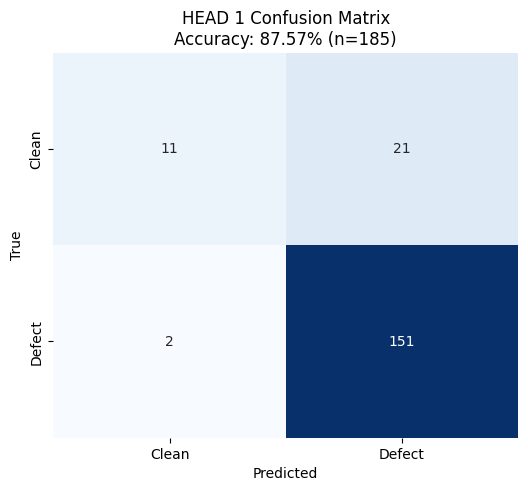


--- Classification Report for H1 ---
              precision    recall  f1-score   support

       Clean       0.85      0.34      0.49        32
      Defect       0.88      0.99      0.93       153

    accuracy                           0.88       185
   macro avg       0.86      0.67      0.71       185
weighted avg       0.87      0.88      0.85       185

------------------------------------------------------------


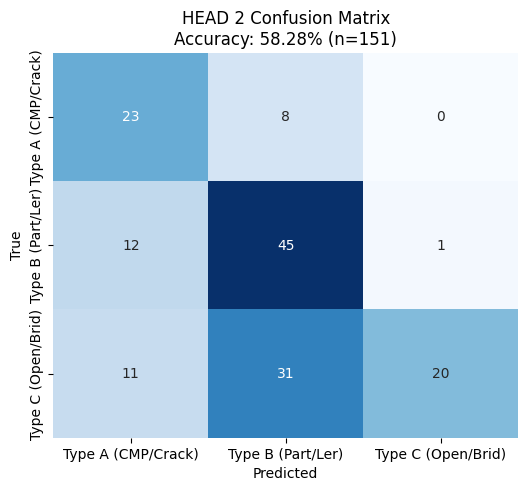


--- Classification Report for H2 ---
                    precision    recall  f1-score   support

Type A (CMP/Crack)       0.50      0.74      0.60        31
 Type B (Part/Ler)       0.54      0.78      0.63        58
Type C (Open/Brid)       0.95      0.32      0.48        62

          accuracy                           0.58       151
         macro avg       0.66      0.61      0.57       151
      weighted avg       0.70      0.58      0.56       151

------------------------------------------------------------


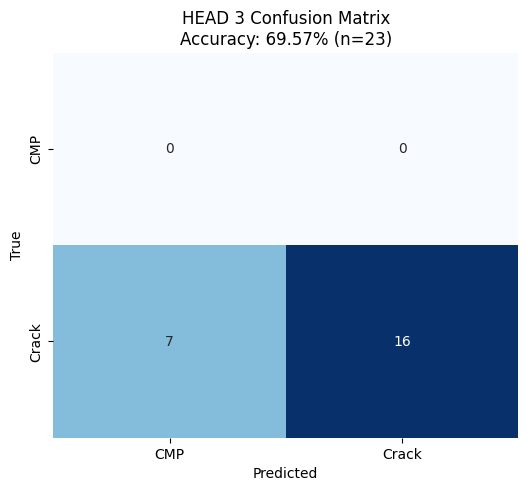


--- Classification Report for H3 ---
              precision    recall  f1-score   support

         CMP       0.00      0.00      0.00         0
       Crack       1.00      0.70      0.82        23

    accuracy                           0.70        23
   macro avg       0.50      0.35      0.41        23
weighted avg       1.00      0.70      0.82        23

------------------------------------------------------------


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


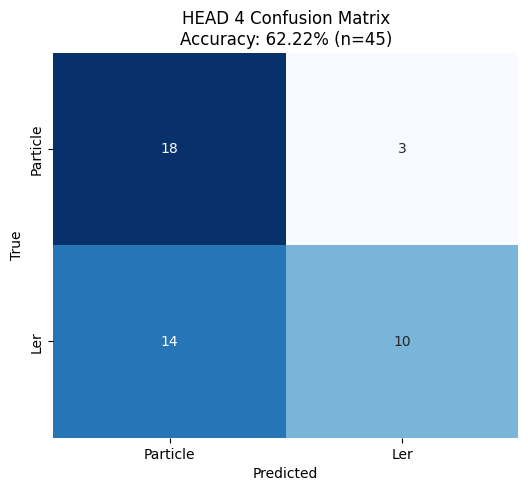


--- Classification Report for H4 ---
              precision    recall  f1-score   support

    Particle       0.56      0.86      0.68        21
         Ler       0.77      0.42      0.54        24

    accuracy                           0.62        45
   macro avg       0.67      0.64      0.61        45
weighted avg       0.67      0.62      0.61        45

------------------------------------------------------------


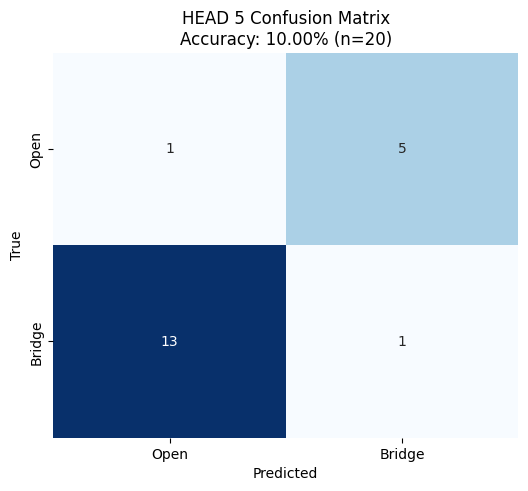


--- Classification Report for H5 ---
              precision    recall  f1-score   support

        Open       0.07      0.17      0.10         6
      Bridge       0.17      0.07      0.10        14

    accuracy                           0.10        20
   macro avg       0.12      0.12      0.10        20
weighted avg       0.14      0.10      0.10        20

------------------------------------------------------------


In [43]:
import torch
import torch.nn as nn
from torchvision import transforms, models
from PIL import Image
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# ==========================================
# 1. CONFIGURATION
# ==========================================
DATASET_ROOT = "/content"
MODEL_FILE = "sem_hierarchical_eiq_final.pth"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Confidence Threshold
H1_THRESHOLD = 0.70

# STRICT LIST of folders to check (Case-Sensitive matches usually required)
TARGET_FOLDERS = ["Clean", "CMP", "Crack", "Particle", "Ler", "Open", "Bridge"]

# ==========================================
# 2. MODEL DEFINITION
# ==========================================
class HierarchicalModel(nn.Module):
    def __init__(self):
        super().__init__()
        base = models.mobilenet_v3_small(weights=None)
        self.backbone = base.features
        self.backbone[0][0] = nn.Conv2d(1, 16, 3, 2, 1, bias=False)
        self.head1 = self._make_head(576, 2)
        self.head2 = self._make_head(576, 3)
        self.head3 = self._make_head(576, 2)
        self.head4 = self._make_head(576, 2)
        self.head5 = self._make_head(576, 2)

    def _make_head(self, in_dim, out_dim):
        return nn.Sequential(
            nn.Linear(in_dim, 128),
            nn.Hardswish(),
            nn.Dropout(0.2),
            nn.Linear(128, out_dim)
        )

    def forward_conditional(self, x):
        preds = {}

        # Backbone
        features = self.backbone(x)
        features = nn.functional.adaptive_avg_pool2d(features, (1, 1)).flatten(1)

        # --- HEAD 1 ---
        logits = self.head1(features)
        probs = torch.softmax(logits, dim=1)
        conf, h1 = torch.max(probs, dim=1)

        preds['h1'] = h1.item()

        if conf.item() < H1_THRESHOLD:
            return preds, "Uncertain"

        if h1.item() == 0:
            return preds, "Normal"

        # --- HEAD 2 ---
        h2 = torch.argmax(self.head2(features), dim=1).item()
        preds['h2'] = h2

        # --- SUBTYPES ---
        if h2 == 0:
            preds['h3'] = torch.argmax(self.head3(features), dim=1).item()
        elif h2 == 1:
            preds['h4'] = torch.argmax(self.head4(features), dim=1).item()
        elif h2 == 2:
            preds['h5'] = torch.argmax(self.head5(features), dim=1).item()

        return preds, "Confident"

# ==========================================
# 3. GROUND TRUTH MAPPER
# ==========================================
def get_ground_truth(folder_name):
    f = folder_name.lower()
    labels = {}

    # H1: Clean vs Defect
    if "clean" in f:
        labels['h1'] = 0
        return labels
    else:
        labels['h1'] = 1

    # H2: Types
    if "cmp" in f or "crack" in f:
        labels['h2'] = 0
        labels['h3'] = 0 if "cmp" in f else 1

    elif "particle" in f or "ler" in f:
        labels['h2'] = 1
        labels['h4'] = 0 if "particle" in f else 1

    elif "open" in f or "bridge" in f:
        labels['h2'] = 2
        labels['h5'] = 0 if "open" in f else 1

    return labels

# ==========================================
# 4. RESTRICTED EVALUATION LOOP
# ==========================================
model = HierarchicalModel().to(device)
if os.path.exists(MODEL_FILE):
    model.load_state_dict(torch.load(MODEL_FILE, map_location=device))
    model.eval()
    print("✅ Model loaded.")
else:
    raise FileNotFoundError("Model file not found!")

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

metrics = {k: {'true': [], 'pred': []} for k in ['h1', 'h2', 'h3', 'h4', 'h5']}
skipped_count = 0
total_images = 0

print(f"Scanning ONLY these folders: {TARGET_FOLDERS}\n")

for target_name in TARGET_FOLDERS:
    # Construct precise path (No recursive globbing on root)
    folder_path = os.path.join(DATASET_ROOT, target_name)

    if not os.path.exists(folder_path):
        print(f"⚠️ Folder '{target_name}' not found. Skipping.")
        continue

    # Find images ONLY in this folder
    image_paths = glob.glob(os.path.join(folder_path, "*.*"))
    valid_exts = ('.jpg', '.jpeg', '.png', '.bmp', '.tif')
    image_paths = [p for p in image_paths if p.lower().endswith(valid_exts)]

    print(f"📂 {target_name}: Found {len(image_paths)} images.")

    # Process images
    for img_path in image_paths:
        total_images += 1

        # Get Truth
        true_labels = get_ground_truth(target_name)

        try:
            img = Image.open(img_path).convert('L')
            img_t = transform(img).unsqueeze(0).to(device)

            with torch.no_grad():
                preds, status = model.forward_conditional(img_t)

            if status == "Uncertain":
                skipped_count += 1
                continue

            # Log Metrics
            for head in metrics:
                if head in true_labels and head in preds:
                    metrics[head]['true'].append(true_labels[head])
                    metrics[head]['pred'].append(preds[head])

        except Exception:
            pass

# ==========================================
# 5. VISUALIZATION (2D MATRICES)
# ==========================================
print(f"\n" + "="*60)
print(f"Total Processed: {total_images}")
print(f"Skipped (Uncertain): {skipped_count} ({(skipped_count/total_images)*100:.1f}%)" if total_images > 0 else "No images found.")
print("="*60)

class_names = {
    'h1': ["Clean", "Defect"],
    'h2': ["Type A (CMP/Crack)", "Type B (Part/Ler)", "Type C (Open/Brid)"],
    'h3': ["CMP", "Crack"],
    'h4': ["Particle", "Ler"],
    'h5': ["Open", "Bridge"]
}

active_heads = [h for h in metrics if len(metrics[h]['true']) > 0]

for head in active_heads:
    y_true = metrics[head]['true']
    y_pred = metrics[head]['pred']

    acc = np.mean(np.array(y_true) == np.array(y_pred)) * 100

    # Plot
    plt.figure(figsize=(6, 5))
    cm = confusion_matrix(y_true, y_pred)

    # Labels
    labels = class_names.get(head, "auto")
    unique_labels = sorted(list(set(y_true) | set(y_pred)))

    # Safety check for label mapping
    if isinstance(labels, list) and len(unique_labels) <= len(labels):
         display_labels = labels
    else:
         display_labels = unique_labels

    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=display_labels, yticklabels=display_labels)

    plt.title(f"HEAD {head[-1]} Confusion Matrix\nAccuracy: {acc:.2f}% (n={len(y_true)})")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

    # Report
    print(f"\n--- Classification Report for {head.upper()} ---")
    if len(unique_labels) == len(display_labels):
        print(classification_report(y_true, y_pred, target_names=display_labels))
    else:
        print(classification_report(y_true, y_pred))
    print("-" * 60)